<a href="https://colab.research.google.com/github/mbargane93/NeuralNetwork/blob/main/Mbargane_AboubacrySENE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [49]:
# 1-Generate a synthetic data for a regression problem which contains 1000 rows and 4 features.
X,Y=make_regression(n_samples=1000,n_features=4,noise=20)

In [50]:
def split_data(X,Y,train_percent):
    np.random.seed(2)
    perm = np.random.permutation(X.shape[0])
    n= X.shape[0]
    train_index = int(train_percent * n)
    x_train = X[perm[:train_index]]
    x_test = X[perm[train_index:]]
    y_train = Y[perm[:train_index]]
    y_test = Y[perm[train_index:]]

    return x_train, x_test, y_train, y_test

In [51]:
x_train, x_test, y_train, y_test =split_data(X,Y, 0.8)

In [52]:
print('x_train.shape',x_train.shape)
print('y_train.shape',y_train.shape)

x_train.shape (800, 4)
y_train.shape (800,)


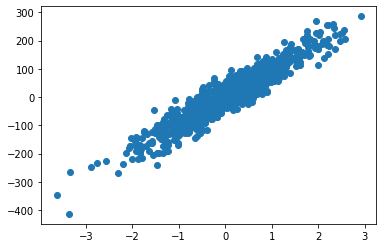

In [54]:
plt.scatter(x_train[:,1], y_train)

In [30]:
# 3-Create a class called NeuralNetworkRegressor of one hidden layer...

In [55]:
class NeuralNetworkRegressor:
    
    def __init__(self, x_test, y_test,batch_size=32, num_epochs= 2500, lr= 0.0001):
        self.batch_size=batch_size
        self.x_test=x_test
        self.y_test=y_test
        self.num_epochs=num_epochs
        self.lr=lr
        self.cost_train=[]
        self.cost_test=[]
        self.acc_train=[]
        self.acc_test=[]
        self.size=(4,16,1) 
        self.params = {
                'w1':np.random.randn(self.size[1],self.size[0])*np.sqrt(1./self.size[0]),
                'b1':np.random.randn(self.size[1],self.size[2])*np.sqrt(1./self.size[0]),
                'w2':np.random.randn(self.size[2],self.size[1])* np.sqrt(1./self.size[1]),
                'b2':np.random.randn(1,1)*np.sqrt(1./self.size[1])
            }
        
    def create_mini_batches(self,x,y):
        mini_batches=[]
        y=y.reshape(-1,1)
        data = np.hstack((x, y))
        np.random.shuffle(data)
        for start in range(0, len(x), self.batch_size):
            stop = start + self.batch_size
            x_batch, y_batch = data[start:stop, :-1], data[start:stop, -1:]
            y_batch=y_batch.flatten()
            mini_batches.append((x_batch, y_batch))
        return mini_batches
       
    def MSE_loss(self,y,y_pred):             
        loss=(1/y.shape[0])*np.sum(np.square(y-y_pred))
        return loss

    
#     w1: an array of shape (hidden_dim, input_dim)
#     b1: an array of shape (hidden_dim, 1). Bias vector
#     w2: an array of shape (output_dim, hidden_dim)
#     b2: an array of shape (1, 1)
  
#     z1: an array of shape (N, hidden_dim)
#     z2: an array of shape (N, output_dim)
        
    def forward_pass(self, x):
    
        params=self.params

        w1= params['w1']
        b1= params['b1']

        w2= params['w2']
        b2= params['b2']

        # ForwardPass
        z1=w1@x.T+b1
        a1= np.tanh(z1) 

        z2=w2@z1+b2
       
        return z1,a1,z2

    def backward_pass(self, x, y):
        params= self.params

        w1= params['w1']
        b1= params['b1']

        w2= params['w2']
        b2= params['b2']

        # Backward

        z1,a1, z2= self.forward_pass(x)
        N= len(y)
        
        dw1= (1/N)*((w2.T@(z2-y))*(1-a1**2))@x
        db1= np.sum((1/N)*((w2.T@(z2-y))*(1-a1**2)),axis=1,keepdims=True)
        
        dw2= (1/N)*(z2-y)@a1.T
        db2= (1./N)*np.sum((z2-y),axis=1,keepdims=True)

        return dw1, db1, dw2, db2
    
    def fit(self, x, y,earling_stop=False):
        last_loss = 100
        max_step = 2
        step = 0
        training = "Epoch {}:, train_accur={:.2f}, train_loss={:.2f}, test_accur={:.2f}, test_loss={:.2f}"
        start_time = time.time()
        for i in range(self.num_epochs):
            mini_batches=self.create_mini_batches(x,y)
            for x_b,y_b in mini_batches:
                
                test_loss=[]
                train_loss=[]

                dw1, db1, dw2, db2 = self.backward_pass(x_b,y_b)
                
                w1=self.params['w1']
                w2=self.params['w2']
                b1=self.params['b1']
                b2=self.params['b2']
              # Update parameters
                w1= w1-(self.lr*dw1)
                b1= b1-(self.lr*db1)


                w2= w2-self.lr*dw2
                b2= b2-self.lr*db2
           
                # Train Loss
                z1,a1, y_pred= self.forward_pass(x_b)
                train_loss.append(self.MSE_loss(y_b,y_pred))

                # Test Loss
                z1,a1,y_pred_test= self.forward_pass(self.x_test)
                test_loss.append(self.MSE_loss(self.y_test,y_pred_test))
                
                # New Paramaters
                self.params={'w1':w1,'b1':b1,'w2':w2,'b2':b2}
                
            train_accuracy =self.accuracy(x_b,y_b)
            test_accuracy=self.accuracy(self.x_test,self.y_test)
            self.acc_train.append(train_accuracy)
            self.acc_test.append(test_accuracy)
            self.cost_train.append(np.mean(train_loss))
            self.cost_test.append(np.mean(test_loss))
            
            # Early stopping
            if earling_stop==True:
                current_loss = np.mean(test_loss)

                if current_loss > last_loss:
                    step += 1

                    if step >= max_step:
                        print('Early stopping!\n This is the best model.')
                        break


                else:
                    step = 0

                last_loss = current_loss
            print(training.format(i+1,train_accuracy, np.mean(train_loss),test_accuracy, np.mean(test_loss)))
            
    #Predict function
    
    def predict(self,x):
        return self.forward_pass(x)[2].squeeze()
    
    # Compute accuracy 
    
    def accuracy(self,x,y):
        y_pred=self.predict(x)
        a=np.sum(np.square(y-y_pred))
        b=np.sum(np.square(y-np.mean(y)))
        R2_score=1-(a/b)
        return R2_score
    #plot losses 
    def plot(self):
        plt.subplot(211)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.plot(np.arange(len(self.cost_train)), self.cost_train, 'r', linewidth = "2", label= 'Train Loss')
        plt.plot(np.arange(len(self.cost_test)), self.cost_test, 'b', linewidth = "2", label= 'Validation Loss')
        plt.legend()
        plt.subplot(212)
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.plot(np.arange(len(self.acc_train)), self.acc_train, 'r', linewidth = "2", label= 'Train Accuracy')
        plt.plot(np.arange(len(self.acc_test)), self.acc_test, 'b', linewidth = "2", label= 'Validation Accuracy')
        plt.legend()
        plt.show()

In [56]:
model=NeuralNetworkRegressor(x_test, y_test)

In [57]:
# 4. Use Mini-batch gradient descent for updating the weights and apply early stopping to select the best model.

In [58]:
model.fit(x_train,y_train,earling_stop=True)

Epoch 1:, train_accur=0.01, train_loss=9589.79, test_accur=0.02, test_loss=11085.00
Epoch 2:, train_accur=0.01, train_loss=5265.68, test_accur=0.04, test_loss=10877.30
Epoch 3:, train_accur=0.06, train_loss=8453.12, test_accur=0.06, test_loss=10658.76
Epoch 4:, train_accur=0.07, train_loss=11327.05, test_accur=0.08, test_loss=10416.56
Epoch 5:, train_accur=0.10, train_loss=7272.92, test_accur=0.11, test_loss=10140.09
Epoch 6:, train_accur=0.08, train_loss=7549.55, test_accur=0.13, test_loss=9835.90
Epoch 7:, train_accur=0.16, train_loss=5695.88, test_accur=0.16, test_loss=9496.47
Epoch 8:, train_accur=0.18, train_loss=8345.62, test_accur=0.20, test_loss=9131.80
Epoch 9:, train_accur=0.23, train_loss=3763.23, test_accur=0.23, test_loss=8727.06
Epoch 10:, train_accur=0.26, train_loss=5706.59, test_accur=0.27, test_loss=8307.82
Epoch 11:, train_accur=0.30, train_loss=3302.70, test_accur=0.31, test_loss=7858.97
Epoch 12:, train_accur=0.34, train_loss=7087.30, test_accur=0.35, test_loss=741

In [59]:
# 5. Compute the validation accuracy.
model.accuracy(x_test,y_test)

0.9638681168243965

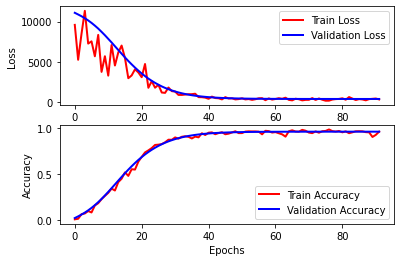

In [60]:
# 6 .Plot the training and validation loss
model.plot()